# Exercise 5 [Direct Transcription Methods]

In [2]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
import itertools

import cvxopt

# Using a quadratic program solver

In this exercise we will learn how to use a QP solver to solve LQ problems as in the model predictive control scheme presented in the class. Here we will use the quadratic program solver from cvxopt (https://cvxopt.org/). The installation instructions for the solver can be found here: https://cvxopt.org/install/index.html

A tutorial on how to use the QP solver can be found here: https://cvxopt.org/examples/tutorial/qp.html

And the function definition to use the QP solver can be found here: https://cvxopt.org/userguide/coneprog.html#quadratic-programming

As a first example, we see how a simple QP can be solved. Consider the following Quadratic Program
$$\min_x \frac{1}{2} x^T \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix} x + \begin{bmatrix} -1 \\ -1 \end{bmatrix}^T x$$
subject to: $$ x_i > 0 \qquad \forall x_i$$
and
$$ \begin{bmatrix} 1 \\ 1 \end{bmatrix}^T x = 1$$

The first constraint just says that each element of $x$ needs to be positive and the second constraint says that the sum of the elements of $x$ needs to be equal to 1. Below is a way to use cvxopt to solve the problem.

In [3]:
# the qp solve of cvxopt accepts problems of the form 0.5 xT P x + qT x, subject to Gx <= h, Ax=b
# in our case we have
P = np.array([[1.,0],[0,1]]) # be careful to write 1. instead of 1 in Python 2.0
q = np.array([[-1.],[-1.]])
G = np.array([[-1.,0],[0,-1.]])
h = np.array([[0.],[0]])
A = np.array([[1.,1]])
b = np.array([[1.]])

# we need to convert numpy arrays into the matrix structures understood by cvxopt
# you could also construct directly matrix objects without passing through numpy 
# here we demonstrate how to go from numpy to cvxopt.matrix because we have used numpy arrays thus far
P = cvxopt.matrix(P)
q = cvxopt.matrix(q)
G = cvxopt.matrix(G)
h = cvxopt.matrix(h)
A = cvxopt.matrix(A)
b = cvxopt.matrix(b)

# now we can just solve the qp by calling the qp function from cvxopt
sol = cvxopt.solvers.qp(P,q,G,h,A,b)
# we convert the solution as a numpy array back
x = np.array(sol['x'])

print('The solution of the problem is x=')
print(x)

     pcost       dcost       gap    pres   dres
 0: -7.5000e-01 -1.7500e+00  1e+00  0e+00  2e+00
 1: -7.5000e-01 -7.6000e-01  1e-02  2e-16  2e-02
 2: -7.5000e-01 -7.5010e-01  1e-04  3e-16  1e-04
 3: -7.5000e-01 -7.5000e-01  1e-06  0e+00  2e-06
 4: -7.5000e-01 -7.5000e-01  1e-08  0e+00  2e-08
Optimal solution found.
The solution of the problem is x=
[[0.5]
 [0.5]]


If we wanted to solve the same problem without the constraint that the sum of the vector components should be equal to 1, we could do it simply by omiting the A and b inputs

In [4]:
# now we can just solve the qp by calling the qp function from cvxopt
sol = cvxopt.solvers.qp(P,q,G,h)
# we convert the solution as a numpy array back
x = np.array(sol['x'])

print('The solution of the problem is x=')
print(x)

     pcost       dcost       gap    pres   dres
 0: -7.5000e-01 -1.7500e+00  1e+00  0e+00  1e+00
 1: -9.4382e-01 -9.5908e-01  2e-02  2e-16  2e-01
 2: -1.0000e+00 -1.0018e+00  2e-03  0e+00  6e-17
 3: -1.0000e+00 -1.0000e+00  2e-05  0e+00  2e-17
 4: -1.0000e+00 -1.0000e+00  2e-07  3e-16  9e-17
Optimal solution found.
The solution of the problem is x=
[[1.00000009]
 [1.00000009]]


# Direct transcription for the car model

Consider a 2 dimensional car model
$$ x_{n+1} = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & \Delta t \\ 0 & 0 & 0 & 1 \end{bmatrix} x_n + \begin{bmatrix} 0 & 0\\ \Delta t & 0 \\ 0 & 0 \\ 0 & \Delta t \end{bmatrix} u_n$$

where the first element of $x_n$ is the car horizontal position, the second element is the horizontal velocity, the third element the vertical position and the last element the vertical velocity. $u_n$ contains the horizontal and vertical acceleration as control inputs.

We would like to get the car from initial position (0,0) to the final goal (5,2) with 0 desired final velocities under the constraints that the maximum acceleration is limited to 5 in each direction. Here we will use $\Delta t = 0.1$ and an horizon length of 100 steps.

## Question 1
Write an optimal control problem (i.e. with a cost and constraints) that could find the desired behavior for the car  (you may encode the desired goal in the cost function).

$$ \min_{\mathbf{u}_n} \mathbf{x}_N^T \mathbf{Q}_N \mathbf{x}_N \sum_{n=0}^{N-1} \mathbf{x}_{n}^T \mathbf{Q}_n \mathbf{x}_n + \mathbf{u}_n^T \mathbf{R}_n \mathbf{u}_n\\
s.t. \ \mathbf{x}_{n+1} = \mathbf{A}_n \mathbf{x}_n + \mathbf{B}_n \mathbf{u}_n$$

## Question 2
We would like to solve the problem using the transcription method shown in the class. 
1. Write a function that finds a  solution to the problem (i.e. a control trajectory and the associated car states).
2. Find weights in your cost function such that the behavior resembles a  bang-bang controller (i.e. minimum time). Plot the resulting control input and state trajectory and use the animation function below to make a movie of the behavior
3. Find weights that reduce the bang bang behavior smoother. As before, plot states and controls and show an animation

## Question 3
Now assume that we add an additional constraint saying that at all times, the sum of the horizontal and vertical velocities of the car cannot be greated than 1. 
1. Write the new optimal control problem.
2. Write a novel function that solves this new problem.
3. How do the trajectories change compared to the case without the constraint? Analyze the resulting behavior, could you have found it manually? (as before, plot trajectories and show an animation)


In [5]:
def solve_direct_transcription(A, B, Q, R, x0, x_des, x_max, u_len, u_max, horizon_length):
    """
    Here we want to find the optimal control path using a direct transcription approach
    
    Inputs: 
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    x_des: the desired goal position
    u_max: the maximum acceleration
    horizon_length: the number of steps
    
    returns: the state and control trajectories
    """    
    
    
    # the length of the state vector for the full trajectory is
    num_states = x0.size*horizon_length
    # the length of the control vector for the full trajectory is
    num_control = u_len*horizon_length
    # the total number of variables is
    num_vars = num_states + num_control
    
    Qtot = np.zeros([num_vars, num_vars])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    btilde[0:x0.size] = -A.dot(x0)
    
    qtilde = np.zeros([num_vars])
    for i in range(horizon_length):
        Qtot[x0.size*i : x0.size*(i+1), x0.size*i : x0.size*(i+1)] = Q
        Qtot[num_states+u_len*i : num_states+u_len*(i+1),
            num_states+u_len*i : num_states+u_len*(i+1)] = R
        
        qtilde[i*x0.size : (i+1)*x0.size] = -x_des.T.dot(Q)
        
        Atilde[x0.size*i : x0.size*(i+1), num_states+u_len*i : num_states+u_len*(i+1)] = B
        
        if i>0 :
            Atilde[x0.size*i : x0.size*(i+1), x0.size*(i-1) : x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i : x0.size*(i+1), x0.size*(i) : x0.size*(i+1)] = -np.eye(x0.size)
    
    Qtot = cvxopt.matrix(Qtot)
    p = cvxopt.matrix(qtilde)
    
    # max torque
    G = np.zeros([2*num_control, num_vars])
    G[:, num_states:] = np.vstack((np.eye(u_len*horizon_length), -np.eye(u_len*horizon_length)))
    h = np.vstack((np.tile(u_max, horizon_length), np.tile(u_max, horizon_length))).flatten()
    
    #max positions
    G = np.vstack((G, np.eye(num_states, num_vars)))
    G = np.vstack((G, -np.eye(num_states, num_vars)))
    tt = np.vstack((np.tile(x_max, horizon_length), np.tile(x_max, horizon_length))).flatten()
    h = np.hstack((h.T, tt.T))
    #h = np.reshape(h, (-1,1))
    #print("h.shape = {} and tt.shape = {}, h.shape = {}".format(h.shape, tt.shape, h.shape))
    
    h = h.astype(np.float64 )
    
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    # the qp solve of cvxopt accepts problems of the form 0.5 xT P x + qT x, subject to Gx <= h, Ax=b
    #sol = cvxopt.solvers.qp(P,q,G,h,A,b)
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde,btilde)
    
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]
    
    x = np.vstack((x0, x.reshape([horizon_length, x0.size]))) 
    return x, u


In [6]:
def animate_car(x, goal):
    """
    This function makes an animation showing the behavior of the car
    takes as input the result of the solve_direct_transcription function 
    and the desired goal (x,y position)
    """
    
    #subsample
    plotx = x[:,:]
    
    fig = matplotlib.figure.Figure(figsize=[10,10])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-2,5.5], ylim=[-2,5.5])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'ob', lw=2)
    list_of_lines.append(line)
    
    car_length = 0.05
    car_height = 0.05
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - car_length
        x_front = plotx[0,i] + car_length
        y_up = plotx[2,i] + car_height
        y_down = plotx[2,i] - car_height
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([goal[0],goal[0]],[goal[1],goal[1]])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=100, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [10]:
import numpy as np
A = np.array([[1, 0.1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0.1], [0, 0, 0, 1]])
B = np.array([[0, 0], [0.1, 0], [0, 0], [0, 0.1]])
Q = np.eye(4)
R = np.array([[0.1, 0.1]])
x0 = np.array([[0], [0], [0], [0]]).flatten()
x_des = np.array([[5], [0], [2], [0]])
xmax = np.array([[1000], [1000], [1000], [1000]])
u_len = 2
u_max = np.array([[5], [5]])
horizon_length = 100

x, u = solve_direct_transcription(A, B, Q, R, x0, x_des, xmax, u_len, u_max, horizon_length)
animate_car(x.T, (5, 2))

     pcost       dcost       gap    pres   dres
 0: -6.7618e+02 -4.1315e+06  4e+06  2e-14  3e-14
 1: -1.0741e+03 -8.7944e+04  9e+04  3e-13  5e-14
 2: -1.2057e+03 -5.2203e+03  4e+03  3e-13  3e-15
 3: -1.2394e+03 -1.5635e+03  3e+02  4e-14  4e-16
 4: -1.2467e+03 -1.2867e+03  4e+01  1e-14  2e-16
 5: -1.2486e+03 -1.2535e+03  5e+00  6e-15  2e-16
 6: -1.2490e+03 -1.2492e+03  2e-01  5e-15  3e-16
 7: -1.2490e+03 -1.2490e+03  7e-03  5e-15  2e-16
 8: -1.2490e+03 -1.2490e+03  2e-04  3e-14  3e-16
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA0AG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTAxIDdkMGZmMjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTggbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAQzmWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADAACbm+OrZzhjPMtiAAADAABi
AARsAG8AFiAEoAFBS38RQjcADbNZx+RKdgtU3HIt5XL0MFMbPLn2k905oqiEGE6gDQIwRTIFVYh0
SouPO/C90ZPd52ahDTQpCAHz75x2+Ajlv0CPyWLQnUi/0iMEb+VGJPUlUpj7ATPpJT3iHb6iyLCf
6fre/i+RfFP3zhe6KcHn3siifSuoJcCMjjqt8VXDmeCwy5tcbZi/IoToHI+5fLTa4ZqnCGbyqRed
lzErfJGM23qfvAxzvHucVxmmqiQRXMgoznZv//J5b8BI9UwwBmzWHkREQnKh9/1XC9fo89PFQsm5
aMj1uXxq1Rg7Y09uV0hyqaQn+/5QoZfT/ESchlvZK6b0huZw8NhV2o1UKWtcMwodTz72vX4RX4tR
rpnCKlwG2VKNElxPZTCx/quCyj2fAgZ/eOctSUZpeA0MhofFKk3EbMhR7Mw/DyQhzwlx78xtSkLS
9RDUjzPpvy0UZ1///zUsf2i82FvsnOxT/rJcgrKqllWxo+aaHAC2b+xz9z1IWg7dp/67e4Bc/Nfa
EdskHT9DBxUOUbP2XK2+W5Ry7ylJCQ29fKcqpTuX0RC/sxLHwP6h/yvX238y/uWkTvFEAcd4YbWx
xtvx6r/yE7p8XSQQAbbWC7KuoibsJ6k4nfWAxnyJ4eSw03oYSTCEVM3sQoU58w03u9vwFR+NXJeb
5VphCIpasAz2Q8S+EBx0yLTyPvS2euGoPtUF0dOnP+Ii+XL/RkKq3VoZY+B+T3Pwh80HVRXaBLRw
onA4BVm3/64AAKd2uo98U1NVg9Zy8cuJqV6r9MtGqUl5dVYbrxYAiV78EssH17Jq1QNzaeKDQH4E
uhkqfceLkjpFgKrVNq7s/ehuexCBHwok7iJUMzhEDXpP9S8/4nrA8ocuu/Wgq/gHoQ6jT+Jv49Pf
n5dM4PgfD+pov6O+BE5wNGgmGYH+fqQjWJBIyNpgI+Kyjl37BVtUJj2cN95sSCnQ5rs/LDq5ry7r
PUuz4BRbbP/5ySj13JGXuzYQjGoqq02p3+m6j0IEUIsE31A16cWd8/W7dF1IZjevaCsznIw+9Pok
mguhPsf8LfhqZdx0z6bx9dHHixUCiTNMfvVM/rDoK1Sci45MqVJBTEYWZOkndT4s6yNyu1BnraTZ
isS3HLZpxzDDYQYXifAF7HDCGu2F9qCxiaMlhasgGGugoUd5IDMeNVHuG6i8/7D3DCu6LCj0UULH
9c+moNekUx6oaPq9YIxf2otrUIfkjhM6hMvFi1zPQELB0L+fPpdZWfI2e732YGpt5Ughbdj8NztM
LiSf41s8TC1YALOchBRpnVTV3F4pFy5hSBzgJV8Zul67piSrXEIEHWwENIzLjQyCsQITKjpud6QU
HcZF55b5VIiHiAElB0AUqQKWpoYYNksPvjzf/7pl57SJ/qCecK9EuNE1ODrFUlcvuEpkn22A61CI
8xYgohcRhRTJ1oLytDdAS1YIrBJlqvv4oNszl+oyZPIM97Go5NF5h6ycz73jn728XKmqm8ulnDnb
RpP1qIuMZfbjRmHPn5uFi6/XxC0GFV9If6Zhpjlvw/6BCueZK2L9NjTd37lMa4Cigc16GJrXMnIP
eoCpnbshgK2AP/E3LB+Vwkwcmx+1f/x2xMRm2T5atNwknFW5F5HJX/gxRFBfmETIGPPigWayBTIg
TqhIjqzJ8I110vHvpYIxqjv1OB2TvBRK7VXRAABuuDleoPGRkLW6MCeGLj/9Cj8oFqo7gZyW5I9Z
JRnFluts/iL8njpY4yAYtfLuWsi9d+MnTQScaIo1UxRGzBen9DaRo7WnP3/yh7d7VK/GwrFDZSIs
w71+y8JknpoliFonwvJETaTXIVpbkVAnyvYIsExst+7KyNtZ6K9lA9Yu5lnTwfZNE10AhcSE+dEq
31ZMB0zg0LVJwrPcXMW3YaCSBCoeqPsc4dS63K/WKTn4uFbVcRbne+9l/9t/JJemE74EIGDJK4qR
HNfVpmHY3SNGbgZqZohoA8bUOXoyTGO1wTXVovc3BH99N1s3k9ziOMMfBPDQNtbgMKYmcw2lvcnu
+EMKjF3VCGEEADiAGrn2kOQMa+CgLwS+8FyIEsRS7oVqYMxrQbod0xiRqSZEuBnHPMvHDis6+UZW
tTXLdLoD8HIyacMAi1wtd8hwKidY4X4VaP+dcEhgKj+A4SZAARcTaKDyT6uU2rS9aBCBGCv84GEi
xe0Ao4f9JoyeR5kYAybA+V1GUDYTR56yMSpIjWf5+G7pnJzZhb1hHh4U0mtF/4tXb7sDi5cUmpPD
m42Cus+IyLgtSk+T6Cmvy1OZS8IRypH+cMSoy8zGUk39oeHrojaLrum1d2mYATNLVbPZckt5Wv8t
P6CZMNxy5VFOxi4ksD/YoiNKyT6O4GZ2lGOndbk5ifanovx+d5s/qyjoiTUep+nqJNP4VAGr1ica
2c5068VP6Vlp6+b5E/Xe7UZgDqBujmDx/z5/f+w/BSFlHnxeMAC/4BM4JU3zrMruop93dHbedoNy
2/M+SBWLR8we/n0mL0db7P8jyYgDHuEVpxqdllkNDBf+KdgwHjvcspqSOOJbN4SZ+cMXX9/bb6cQ
llynwjzXiU2QIF3bWuCCa3g625+rnIwHK+ZLxqaur0736GcEmRS4WddtsH3v5PV+jmG1I4uHVJRN
qjTxhMf5J4lC32QZ+kA32TRhd/s+ZKzAyROEPBBohOLEdvydAr7JyEnRa0EaakgkOwu/ZAsnkpn0
4dpK2J9mT3mOZxsE/ai2WvsyIz1TuitWwCCauKH69fmLqTwWnuwrCuT6lEyatkmlOl3fDn0vmE8A
fdNP+s+36cw1AJ7dbHYwy

<IPython.core.display.Javascript object>


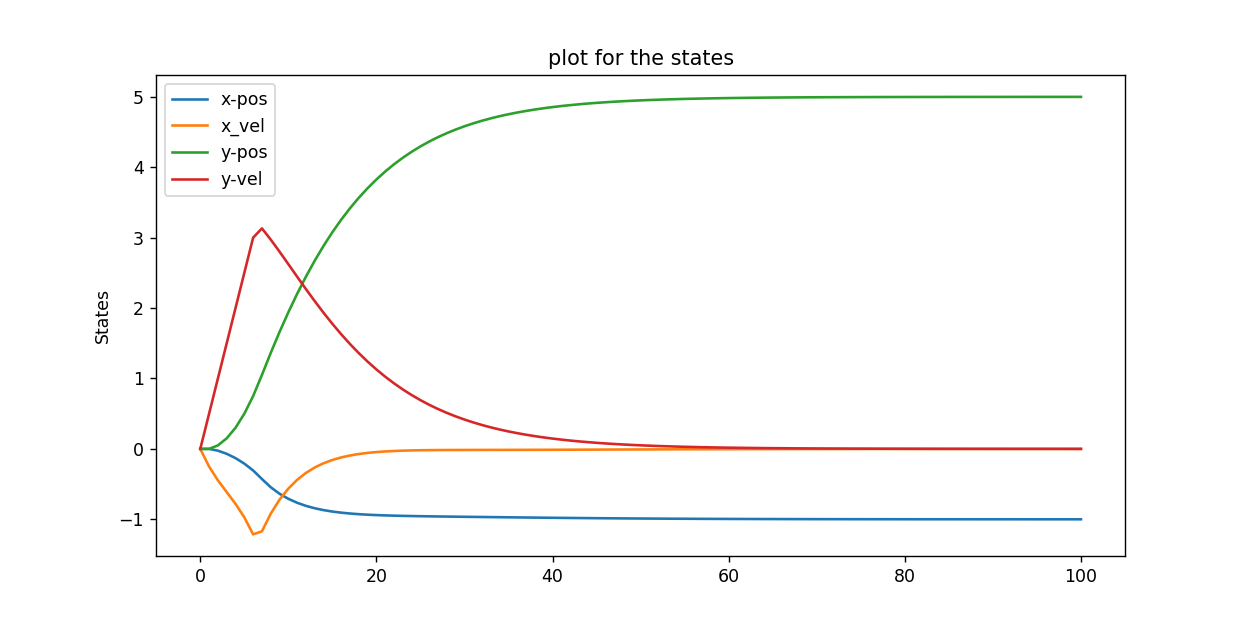

In [8]:
plt.figure(figsize=(10, 5))
t = [i for i in range(101)]
plt.title('plot for the states')
plt.ylabel('States')
states = ['x-pos', 'x_vel', 'y-pos', 'y-vel']
plt.plot(t, x)
plt.legend(states)
plt.show()

In [33]:
import numpy as np
x = np.array([-1, 0, 1, 2, -1, -4])
# x = sorted(x)

ret = set()
# ret=[]
for i in range(len(x)-2):
    for j in range(i+1, len(x)-1):
        for k in range(j+1, len(x)):
            if x[i]+x[j]+x[k] == 0:
                ret.add((x[i], x[j], x[k]))
#                   ret.append((x[i], x[j], x[k]))

In [34]:
ret

{(-1, 0, 1), (-1, 2, -1), (0, 1, -1)}

In [32]:
x = (-1, 0, 1)
y = (-1, -1, 0)
x == y

False

In [11]:
nums = np.array([-1, 0, 1, 2, -1, -4])

nums = sorted(nums)
ret = []
for i in range(0, len(nums)-2):
    for j in range(i+1, len(nums)-1):
        for k in range(j+1, len(nums)):
            if nums[i]+nums[j]+nums[k] == 0:
                ret.append((nums[i], nums[j], nums[k]))


     pcost       dcost       gap    pres   dres
 0: -1.2971e+06 -1.3771e+06  8e+05  8e+00  1e-02
 1: -1.2906e+06 -1.3794e+06  6e+05  5e+00  7e-03
 2: -1.2860e+06 -1.3756e+06  4e+05  2e+00  4e-03
 3: -1.2803e+06 -1.3614e+06  2e+05  1e+00  2e-03
 4: -1.2748e+06 -1.3344e+06  2e+05  7e-01  1e-03
 5: -1.2610e+06 -1.2959e+06  1e+05  5e-01  8e-04
 6: -1.2402e+06 -1.2539e+06  1e+05  3e-01  5e-04
 7: -1.2293e+06 -1.2322e+06  1e+05  3e-01  4e-04
 8: -1.2011e+06 -1.1924e+06  8e+04  2e-01  3e-04
 9: -1.1754e+06 -1.1676e+06  7e+04  1e-01  2e-04
10: -1.1505e+06 -1.1485e+06  5e+04  6e-02  8e-05
11: -1.1292e+06 -1.1325e+06  3e+04  2e-02  3e-05
12: -1.1160e+06 -1.1180e+06  5e+03  3e-03  4e-06
13: -1.1144e+06 -1.1144e+06  9e+01  5e-05  7e-08
14: -1.1143e+06 -1.1143e+06  1e+00  6e-07  9e-10
15: -1.1143e+06 -1.1143e+06  1e-02  6e-09  9e-12
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA2YG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTAxIDdkMGZmMjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTggbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAQzGWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADAACbm+OrZzhjPMtiAAADAABi
AARsAG8AFiAEoAFBS38RQjcADbNZx+RKdgtU3HIt5XL0MFMbPLn2k905oqiEGE6gDQIwRTIFVYh0
SouPO/C90ZPd52ahDTQpCAHz75x2+Ajlv0CPyWLQnUi/0iMEb+VGJPUlUpj7ATPpJT3iHb6iyLCf
6fre/i+RfFP3zhe6KcHn3siifSuoJcCMjjqt8VXDmeCwy5tcbZi/IoToHI+5fLTa4ZqnCGbyqRed
lzErfJGM23qfvAxzvHucVxmmqiQRXMgoznZv//J5b8BI9UwwBmzWHkREQnKh9/1XC9fo89PFQsm5
aMj1uXxq1Rg7Y09uV0hyqaQn+/5QoZfT/ESchlvZK6b0huZw8NhV2o1UKWtcMwodTz72vX4RX4tR
rpnCKlwG2VKNElxPZTCx/quCyj2fAgZ/eOctSUZpeA0MhofFKk3EbMhR7Mw/DyQhzwlx78xtSkLS
9RDUjzPpvy0UZ1///zUsf2i82FvsnOxT/rJcgrKqllWxo+aaHAC2b+xz9z1IWg7dp/67e4Bc/Nfa
EdskHT9DBxUOUbP2XK2+W5Ry7ylJCQ29fKcqpTuX0RC/sxLHwP6h/yvX238y/uWkTvFEAcd4YbWx
xtvx6r/yE7p8XSQQAbbWC7KuoibsJ6k4nfWAxnyJ4eSw03oYSTCEVM3sQoU58w03u9vwFR+NXJeb
5VphCIpasAz2Q8S+EBx0yLTyPvS2euGoPtUF0dOnP+Ii+XL/RkKq3VoZY+B+T3Pwh80HVRXaBLRw
onA4BVm3/64AAKd2uo98U1NVg9Zy8cuJqV6r9MtGqUl5dVYbrxYAiV78EssH17Jq1QNzaeKDQH4E
uhkqfceLkjpFgKrVNq7s/ehuexCBHwok7iJUMzhEDXpP9S8/4nrA8ocuu/Wgq/gHoQ6jT+Jv49Pf
n5dM4PgfD+pov6O+BE5wNGgmGYH+fqQjWJBIyNpgI+Kyjl37BVtUJj2cN95sSCnQ5rs/LDq5ry7r
PUuz4BRbbP/5ySj13JGXuzYQjGoqq02p3+m6j0IEUIsE31A16cWd8/W7dF1IZjevaCsznIw+9Pok
mguhPsf8LfhqZdx0z6bx9dHHixUCiTNMfvVM/rDoK1Sci45MqVJBTEYWZOkndT4s6yNyu1BnraTZ
isS3HLZpxzDDYQYXifAF7HDCGu2F9qCxiaMlhasgGGugoUd5IDMeNVHuG6i8/7D3DCu6LCj0UULH
9c+moNekUx6oaPq9YIxf2otrUIfkjhM6hMvFi1zPQELB0L+fPpdZWfI2e732YGpt5Ughbdj8NztM
LiSf41s8TC1YALOchBRpnVTV3F4pFy5hSBzgJV8Zul67piSrXEIEHWwENIzLjQyCsQITKjpud6QU
HcZF55b5VIiHiAElB0AUqQKWpoYYNksPvjzf/7pl57SJ/qCecK9EuNE1ODrFUlcvuEpkn22A61CI
8xYgohcRhRTJ1oLytDdAS1YIrBJlqvv4oNszl+oyZPIM97Go5NF5h6ycz73jn728XKmqm8ulnDnb
RpP1qIuMZfbjRmHPn5uFi6/XxC0GFV9If6Zhpjlvw/6BCueZK2L9NjTd37lMa4Cigc16GJrXMnIP
eoCpnbshgK2AP/E3LB+Vwkwcmx+1f/x2xMRm2T5atNwknFW5F5HJX/gxRFBfmETIGPPigWayBTIg
TqhIjqzJ8I110vHvpYIxqjv1OB2TvBRK7VXRAABuuDleoPGRkLW6MCeGLj/9Cj8oFqo7gZyW5I9Z
JRnFluts/iL8njpY4yAYtfLuWsi9d+MnTQScaIo1UxRGzBen9DaRo7WnP3/yh7d7VK/GwrFDZSIs
w71+y8JknpoliFonwvJETaTXIVpbkVAnyvYIsExst+7KyNtZ6K9lA9Yu5lnTwfZNE10AhcSE+dEq
31ZMB0zg0LVJwrPcXMW3YaCSBCoeqPsc4dS63K/WKTn4uFbVcRbne+9l/9t/JJemE74EIGDJK4qR
HNfVpmHY3SNGbgZqZohoA8bUOXoyTGO1wTXVovc3BH99N1s3k9ziOMMfBPDQNtbgMKYmcw2lvcnu
+EMKjF3VCGEEADiAGrn2kOQMa+CgLwS+8FyIEsRS7oVqYMxrQbod0xiRqSZEuBnHPMvHDis6+UZW
tTXLdLoD8HIyacMAi1wtd8hwKidY4X4VaP+dcEhgKj+A4SZAARcTaKDyT6uU2rS9aBCBGCv84GEi
xe0Ao4f9JoyeR5kYAybA+V1GUDYTR56yMSpIjWf5+G7pnJzZhb1hHh4U0mtF/4tXb7sDi5cUmpPD
m42Cus+IyLgtSk+T6Cmvy1OZS8IRypH+cMSoy8zGUk39oeHrojaLrum1d2mYATNLVbPZckt5Wv8t
P6CZMNxy5VFOxi4ksD/YoiNKyT7dTgzG0oxx9FjueH3U46Xli/jL6d3e55QxfNK8TdVHl/qwE3Wx
DaGd0xeCghr/sZEys2nluy+LxYQnm4WxTW1twnPlUNFEHhlSq3dM8WGm29Vf1H9pfRnBNbz/oGHX
hfrLU8i1q+Cwwmq7ciz/eNSw+Bub2gvlH0yRGs2e3clSP+ZXjaWoKRZVSqgQG9sYgQg/4WJRARmQ
jujaLtUBThVZdg5hGZEO9utpQf72pe47s375hdKyuWaAJHr3IQVfp4cy6FWNz0wOK24nK5bdxF8X
9fO5SE5s3MLGkafwQSZ9C+y7+J5+N8AI+Y7jLMHXufTsCVzkJOi1oI0/sei0/tH1s4vEwFEQ7Vjs
GiEmS5QCtl1HL8OZxsE/ai2WvbY+m0uAXxsFZxhHxzRL6afLR8vmrprsEYS9vdTXv04Ulszb5wcX
FLPZzTC9t19IX3IDzFUo+

<IPython.core.display.Javascript object>


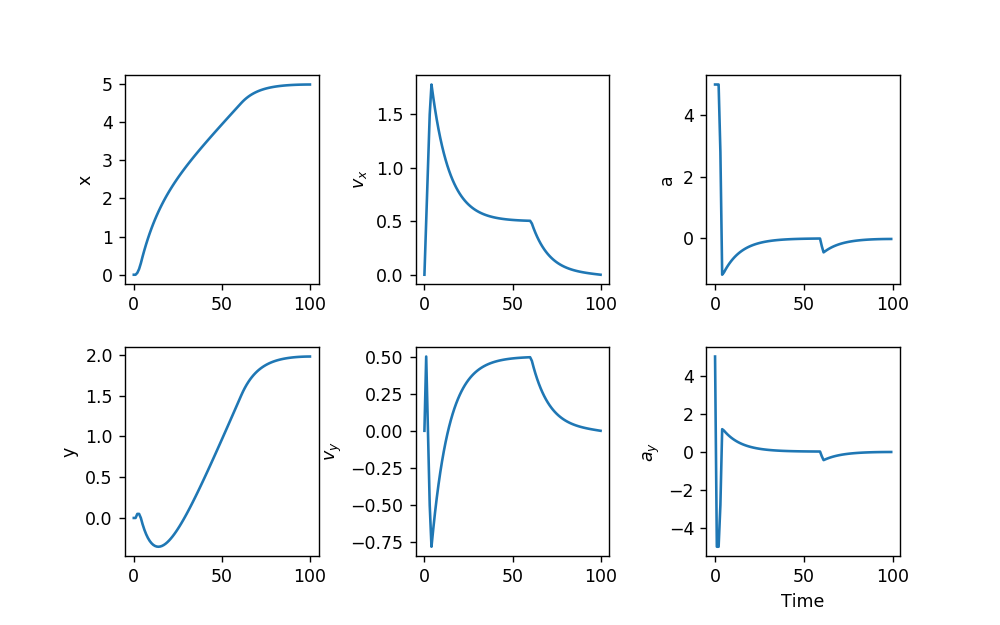

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA2YG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTAxIDdkMGZmMjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTggbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAQzGWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADAACbm+OrZzhjPMtiAAADAABi
AARsAG8AFiAEoAFBS38RQjcADbNZx+RKdgtU3HIt5XL0MFMbPLn2k905oqiEGE6gDQIwRTIFVYh0
SouPO/C90ZPd52ahDTQpCAHz75x2+Ajlv0CPyWLQnUi/0iMEb+VGJPUlUpj7ATPpJT3iHb6iyLCf
6fre/i+RfFP3zhe6KcHn3siifSuoJcCMjjqt8VXDmeCwy5tcbZi/IoToHI+5fLTa4ZqnCGbyqRed
lzErfJGM23qfvAxzvHucVxmmqiQRXMgoznZv//J5b8BI9UwwBmzWHkREQnKh9/1XC9fo89PFQsm5
aMj1uXxq1Rg7Y09uV0hyqaQn+/5QoZfT/ESchlvZK6b0huZw8NhV2o1UKWtcMwodTz72vX4RX4tR
rpnCKlwG2VKNElxPZTCx/quCyj2fAgZ/eOctSUZpeA0MhofFKk3EbMhR7Mw/DyQhzwlx78xtSkLS
9RDUjzPpvy0UZ1///zUsf2i82FvsnOxT/rJcgrKqllWxo+aaHAC2b+xz9z1IWg7dp/67e4Bc/Nfa
EdskHT9DBxUOUbP2XK2+W5Ry7ylJCQ29fKcqpTuX0RC/sxLHwP6h/yvX238y/uWkTvFEAcd4YbWx
xtvx6r/yE7p8XSQQAbbWC7KuoibsJ6k4nfWAxnyJ4eSw03oYSTCEVM3sQoU58w03u9vwFR+NXJeb
5VphCIpasAz2Q8S+EBx0yLTyPvS2euGoPtUF0dOnP+Ii+XL/RkKq3VoZY+B+T3Pwh80HVRXaBLRw
onA4BVm3/64AAKd2uo98U1NVg9Zy8cuJqV6r9MtGqUl5dVYbrxYAiV78EssH17Jq1QNzaeKDQH4E
uhkqfceLkjpFgKrVNq7s/ehuexCBHwok7iJUMzhEDXpP9S8/4nrA8ocuu/Wgq/gHoQ6jT+Jv49Pf
n5dM4PgfD+pov6O+BE5wNGgmGYH+fqQjWJBIyNpgI+Kyjl37BVtUJj2cN95sSCnQ5rs/LDq5ry7r
PUuz4BRbbP/5ySj13JGXuzYQjGoqq02p3+m6j0IEUIsE31A16cWd8/W7dF1IZjevaCsznIw+9Pok
mguhPsf8LfhqZdx0z6bx9dHHixUCiTNMfvVM/rDoK1Sci45MqVJBTEYWZOkndT4s6yNyu1BnraTZ
isS3HLZpxzDDYQYXifAF7HDCGu2F9qCxiaMlhasgGGugoUd5IDMeNVHuG6i8/7D3DCu6LCj0UULH
9c+moNekUx6oaPq9YIxf2otrUIfkjhM6hMvFi1zPQELB0L+fPpdZWfI2e732YGpt5Ughbdj8NztM
LiSf41s8TC1YALOchBRpnVTV3F4pFy5hSBzgJV8Zul67piSrXEIEHWwENIzLjQyCsQITKjpud6QU
HcZF55b5VIiHiAElB0AUqQKWpoYYNksPvjzf/7pl57SJ/qCecK9EuNE1ODrFUlcvuEpkn22A61CI
8xYgohcRhRTJ1oLytDdAS1YIrBJlqvv4oNszl+oyZPIM97Go5NF5h6ycz73jn728XKmqm8ulnDnb
RpP1qIuMZfbjRmHPn5uFi6/XxC0GFV9If6Zhpjlvw/6BCueZK2L9NjTd37lMa4Cigc16GJrXMnIP
eoCpnbshgK2AP/E3LB+Vwkwcmx+1f/x2xMRm2T5atNwknFW5F5HJX/gxRFBfmETIGPPigWayBTIg
TqhIjqzJ8I110vHvpYIxqjv1OB2TvBRK7VXRAABuuDleoPGRkLW6MCeGLj/9Cj8oFqo7gZyW5I9Z
JRnFluts/iL8njpY4yAYtfLuWsi9d+MnTQScaIo1UxRGzBen9DaRo7WnP3/yh7d7VK/GwrFDZSIs
w71+y8JknpoliFonwvJETaTXIVpbkVAnyvYIsExst+7KyNtZ6K9lA9Yu5lnTwfZNE10AhcSE+dEq
31ZMB0zg0LVJwrPcXMW3YaCSBCoeqPsc4dS63K/WKTn4uFbVcRbne+9l/9t/JJemE74EIGDJK4qR
HNfVpmHY3SNGbgZqZohoA8bUOXoyTGO1wTXVovc3BH99N1s3k9ziOMMfBPDQNtbgMKYmcw2lvcnu
+EMKjF3VCGEEADiAGrn2kOQMa+CgLwS+8FyIEsRS7oVqYMxrQbod0xiRqSZEuBnHPMvHDis6+UZW
tTXLdLoD8HIyacMAi1wtd8hwKidY4X4VaP+dcEhgKj+A4SZAARcTaKDyT6uU2rS9aBCBGCv84GEi
xe0Ao4f9JoyeR5kYAybA+V1GUDYTR56yMSpIjWf5+G7pnJzZhb1hHh4U0mtF/4tXb7sDi5cUmpPD
m42Cus+IyLgtSk+T6Cmvy1OZS8IRypH+cMSoy8zGUk39oeHrojaLrum1d2mYATNLVbPZckt5Wv8t
P6CZMNxy5VFOxi4ksD/YoiNKyT7dTgzG0oxx9FjueH3U46Xli/jL6d3e55QxfNK8TdVHl/qwE3Wx
DaGd0xeCghr/sZEys2nluy+LxYQnm4WxTW1twnPlUNFEHhlSq3dM8WGm29Vf1H9pfRnBNbz/oGHX
hfrLU8i1q+Cwwmq7ciz/eNSw+Bub2gvlH0yRGs2e3clSP+ZXjaWoKRZVSqgQG9sYgQg/4WJRARmQ
jujaLtUBThVZdg5hGZEO9utpQf72pe47s375hdKyuWaAJHr3IQVfp4cy6FWNz0wOK24nK5bdxF8X
9fO5SE5s3MLGkafwQSZ9C+y7+J5+N8AI+Y7jLMHXufTsCVzkJOi1oI0/sei0/tH1s4vEwFEQ7Vjs
GiEmS5QCtl1HL8OZxsE/ai2WvbY+m0uAXxsFZxhHxzRL6afLR8vmrprsEYS9vdTXv04Ulszb5wcX
FLPZzTC9t19IX3IDzFUo+

In [12]:
def solve_direct_transcription_new(A,B,Q,R,x0,horizon_length, u_max, u_len,x_des):
    """
    Here we want to find the optimal control path using a direct transcription approach

    Inputs:
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    x_des: the desired goal position
    u_max: the maximum acceleration
    horizon_length: the number of steps

    returns: the state and control trajectories
    """
    # the lenght of the state vector for the full trajectory is
    num_states = x0.size * horizon_length
    #  the length of the control vector for the full trajectory is
    num_control = u_len * horizon_length
    #  the total number of variables is
    num_vars = num_states + num_control


    # ######################################################################
    # ###  here you need to construct the problem as a quadratic program ###
    # ######################################################################
    # ## P: num_vars * num_vars will contain the cost quadratic term
    # ## q: num_vars * 1 will contain the cost linear term
    # ## G: will contain the inequality contraints (max acceleration)
    # ## h: will contain the max and min acceleration
    # ## A and b: will contain the equality constraints associtated to the system dynamics
    Qt = np.zeros([num_vars, num_vars])
    At = np.zeros([num_states, num_vars])
    bt = np.zeros([num_states])
    bt[0:x0.size] = -A.dot(x0)

    qt = np.zeros([num_vars])
    for i in range(horizon_length):
        Qt[x0.size * i:x0.size * (i + 1), x0.size * i:x0.size * (i + 1)] = Q
        Qt[num_states + u_len * i:num_states + u_len * (i + 1),
        num_states + u_len * i:num_states + u_len * (i + 1)] = R

        qt[i * x0.size:(i + 1) * x0.size] = -x_des[:, i].dot(Q)
        At[x0.size * i:x0.size * (i + 1), num_states + u_len * i:num_states + u_len * (i + 1)] = B

        if i > 0:
            At[x0.size * i:x0.size * (i + 1), x0.size * (i - 1):x0.size * (i + 1)] = \
                np.hstack((A, -np.eye(x0.size)))
        # print(P.shape,q.shape)
        else:
            At[x0.size * i:x0.size * (i + 1), x0.size * i:x0.size * (i + 1)] = -np.eye(x0.size)
    P=cvxopt.matrix(Qt)
    q=cvxopt.matrix(qt)

    # max acceleration and velocity constraint
    G1=np.zeros([2*num_control,num_vars])
    G1[:,num_states:]=np.vstack((np.eye(u_len*horizon_length),-np.eye(u_len*horizon_length)))
    h1=np.vstack((np.tile(u_max,u_len*horizon_length),np.tile(u_max,u_len*horizon_length))).flatten()
    G2=np.zeros([horizon_length,num_vars])
    for i in range(horizon_length):
        G2[i,x0.size*i:x0.size*(i+1)] = np.array([0.,1.,0.,1.])
    h2 = np.ones((horizon_length,1)).flatten()
    h = np.hstack((h2,h1)).flatten()
    G = np.vstack((G2,G1))
    
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    
    A=cvxopt.matrix(At)
    b=cvxopt.matrix(bt)

    # # once the problem is constructed we can call the solver
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    x = np.array(sol['x'])

    ## we assume that the problem was constructed with the states first (x0,x1,...)
    ## and then the control inputs (u0, u1, ...)

    # we extract the control trajectory as a 2 * horizon_length array
    u = (x[num_states:].reshape(horizon_length, 2)).transpose()

    # we extract the state trajectory and add the initial condition
    x = x[0:num_states]
    x = np.vstack((x0, x.reshape([horizon_length, x0.size]))).transpose()

    return x, u

u_max = 5.
dt = 0.1
horizon_length = 100

Q = np.array([[1000., 0., 0., 0.], [0., 1000., 0., 0.], [0., 0., 1000., 0.], [0., 0., 0., 1000.]])
R = np.array([[0.1, 0.], [0., 0.1]])

x0 = np.array([0.,0.,0.,0.])

A = np.array([[1., dt, 0., 0.], [0, 1., 0, 0], [0, 0, 1, dt], [0., 0., 0, 1]])
B = np.array([[0., 0], [dt, 0.], [0, 0], [0., dt]])

u_len = 2
x_des = np.tile(np.array([[5.],[0.],[2.],[0.]]),horizon_length)

x,u = solve_direct_transcription_new(A,B,Q,R,x0,horizon_length, u_max, u_len,x_des)
# print(x,u)
animate_car(x, (5,2))

plt.figure(figsize=(8,5))
plt.subplots_adjust(wspace =0.5, hspace =0.3)
plt.subplot(2,3,1)
plt.plot(x[0,:])
plt.ylabel('x')
plt.subplot(2,3,2)
plt.plot(x[1,:])
plt.ylabel('$v_x$')
plt.subplot(2,3,3)
plt.plot(u[0,:])
plt.ylabel('a')
plt.subplot(2,3,4)
plt.plot(x[2,:])
plt.ylabel('y')
plt.subplot(2,3,5)
plt.plot(x[3,:])
plt.ylabel(r'$v_y$')
plt.subplot(2,3,6)
plt.plot(u[1,:])
plt.ylabel(r'$a_y$')
plt.xlabel('Time')
animate_car(x,(5,2))